# Universidad Abierta y a Distancia.
## Estudiante: Brayan Manuel Granados Navarro.
### Arból de decisión.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Cargar datos
data = pd.read_csv('C:/Users/brayg/OneDrive - Universidad Nacional Abierta y a Distancia/UNAD/2025/PERIODO 16-01/ANÁLISIS DE DATOS/Tarea 3 - Algoritmos de Aprendizaje Supervisado/winequality-red.csv')

In [12]:
# Estructura básica
print("Filas, columnas:", data.shape)
print("\nPrimeras filas:\n", data.head())

Filas, columnas: (1599, 12)

Primeras filas:
    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        

In [14]:
# Estructura básica
print("\nEstadísticas descriptivas:\n", data.describe())


Estadísticas descriptivas:
        fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000 

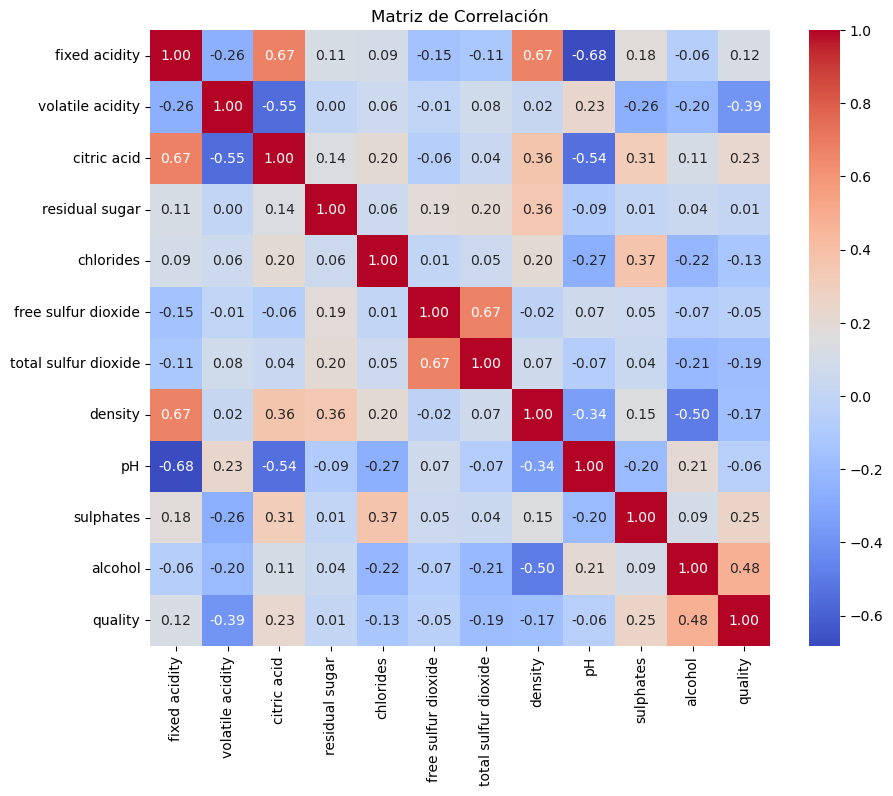

In [16]:
# Relaciones entre variables (Matriz de correlación)
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

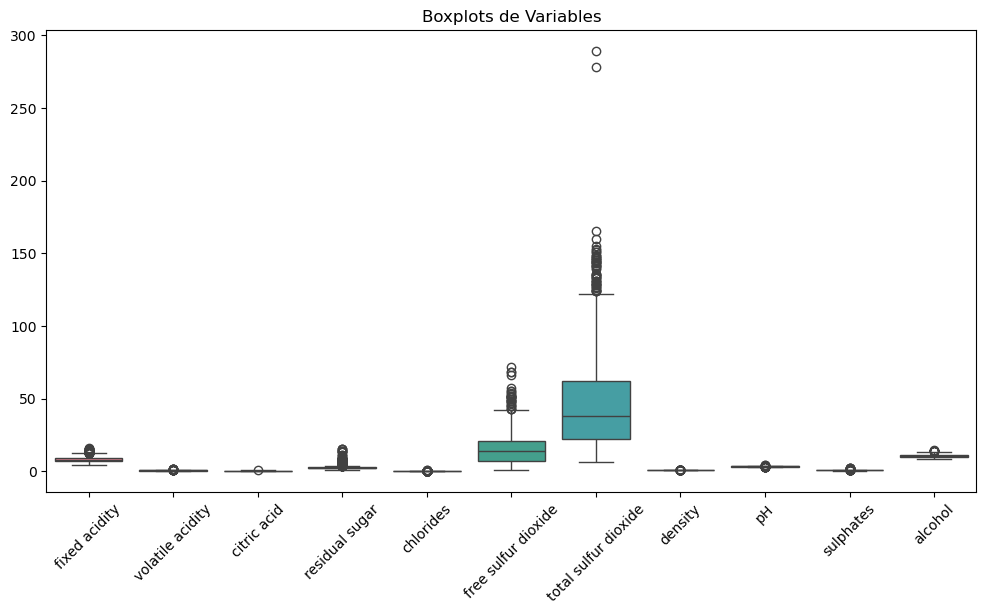

In [18]:
# Valores atípicos (Boxplots)
plt.figure(figsize=(12, 6))
sns.boxplot(data=data.drop("quality", axis=1))
plt.xticks(rotation=45)
plt.title("Boxplots de Variables")
plt.show()

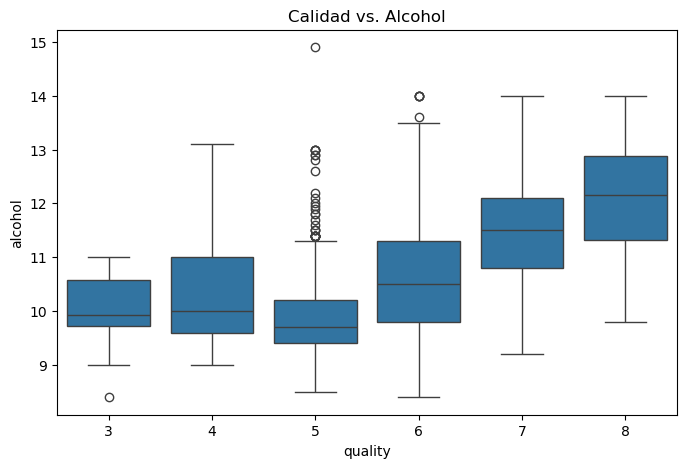

In [20]:
# Tendencia: Calidad vs. Alcohol
plt.figure(figsize=(8, 5))
sns.boxplot(x="quality", y="alcohol", data=data)
plt.title("Calidad vs. Alcohol")
plt.show()

In [25]:
# Valores faltantes (no hay en este dataset)
print("Valores faltantes por columna:\n", data.isnull().sum())

Valores faltantes por columna:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [38]:
# Transformación: Clasificación binaria
data["quality_binary"] = np.where(data["quality"] >= 7, 1, 0)  # 1=Bueno, 0=Regular

# Escalado (StandardScaler para modelos no basados en árboles)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = data.drop(["quality", "quality_binary"], axis=1)
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
y = data["quality_binary"]

In [44]:
from sklearn.feature_selection import SelectKBest, f_classif

# Selección basada en ANOVA
selector = SelectKBest(score_func=f_classif, k=5)  # Top 5 características
X_selected = selector.fit_transform(X, y)

# Obtener nombres de las características seleccionadas
selected_features = X.columns[selector.get_support()]
print("Características seleccionadas:\n", selected_features)

Características seleccionadas:
 Index(['volatile acidity', 'citric acid', 'density', 'sulphates', 'alcohol'], dtype='object')


In [46]:
# Importancia con árbol de decisión (alternativa)
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X, y)
importance = pd.DataFrame({"Feature": X.columns, "Importance": model_rf.feature_importances_})
importance = importance.sort_values(by="Importance", ascending=False)
print("\nImportancia de características (Random Forest):\n", importance.head(5))


Importancia de características (Random Forest):
              Feature  Importance
10           alcohol    0.168133
9          sulphates    0.117851
1   volatile acidity    0.112176
7            density    0.097678
2        citric acid    0.093253


In [48]:
from sklearn.model_selection import train_test_split

# Usar características seleccionadas
X = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("\nTamaño de Train y Test:", X_train.shape, X_test.shape)


Tamaño de Train y Test: (1119, 5) (480, 5)


In [155]:
from sklearn.tree import DecisionTreeClassifier

# Modelo
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Optimización con GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid = {
    "max_depth": [3, 5, 7, None],
    "min_samples_split": [2, 5, 10],
    "criterion": ["gini", "entropy"]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("\nMejores hiperparámetros:", grid_search.best_params_)


Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}


In [156]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predicciones
y_pred = best_model.predict(X_test)

In [170]:
# Métricas
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))
print("\nPrecisión:", accuracy_score(y_test, y_pred))


Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92       413
           1       0.52      0.25      0.34        67

    accuracy                           0.86       480
   macro avg       0.70      0.61      0.63       480
weighted avg       0.84      0.86      0.84       480


Precisión: 0.8625


<Figure size 800x600 with 0 Axes>

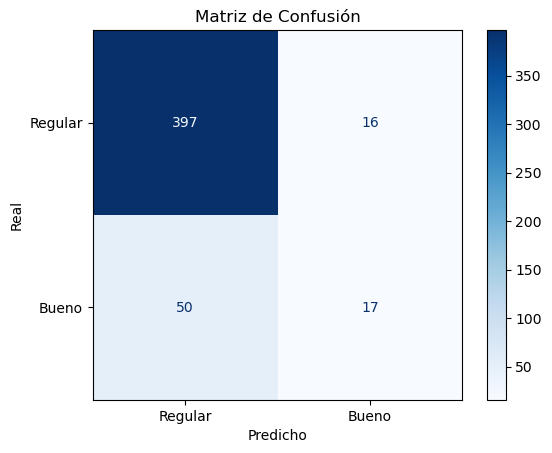

In [174]:
# Matriz de confusión

from sklearn.metrics import classification_report, confusion_matrix, PrecisionRecallDisplay, accuracy_score, roc_auc_score, ConfusionMatrixDisplay

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test,
                                    display_labels=['Regular', 'Bueno'],
                                    cmap="Blues",
                                    values_format='d')
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

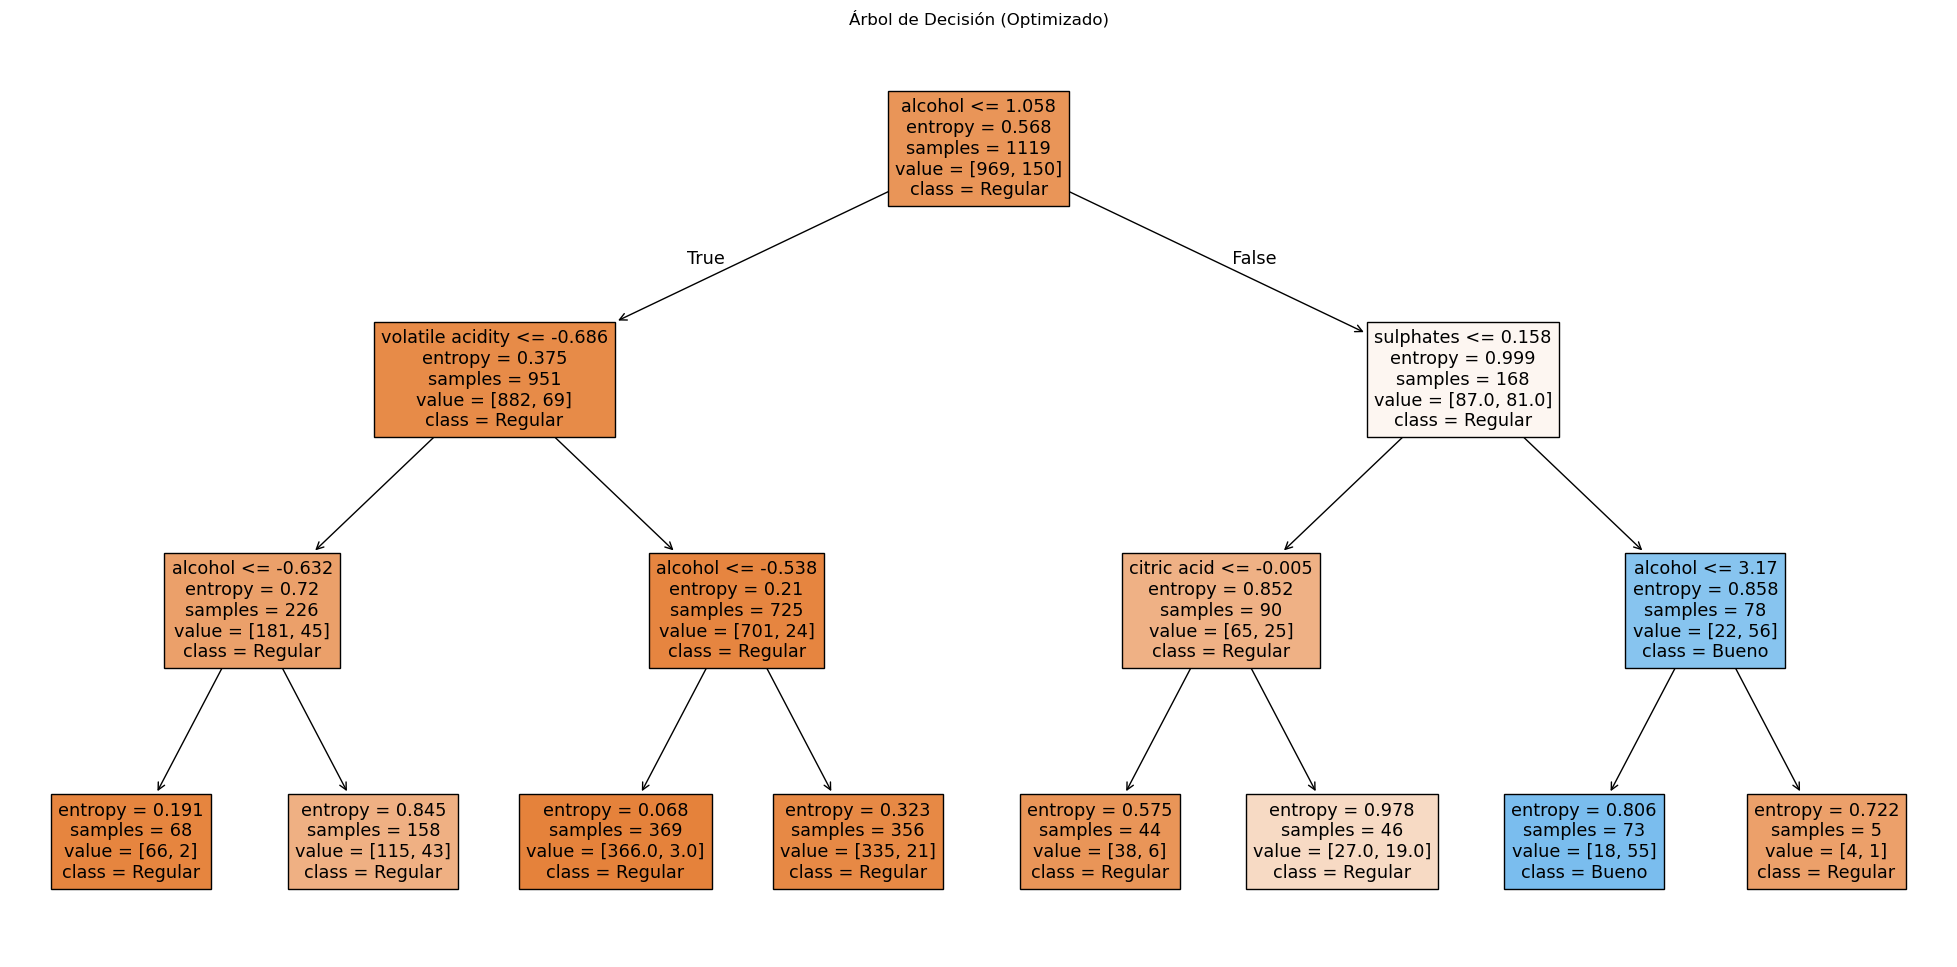

In [163]:
# Árbol de decisión (primeros 3 niveles)
from sklearn.tree import plot_tree
plt.figure(figsize=(25, 12))
plot_tree(best_model, feature_names=selected_features, class_names=["Regular", "Bueno"], max_depth=3, filled=True)
plt.title("Árbol de Decisión (Optimizado)")
plt.show()


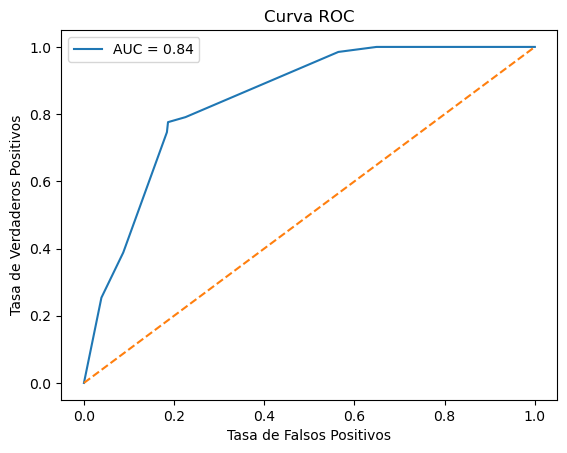

In [113]:
# Curva ROC (opcional)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend()
plt.show()

De acuerdo a la matriz de correlación el alcohol vs quality tienen una correlación positiva moderada de (0.48) de todas las que estan referenciadas, por lo cual se puede concluir que el alcohol es un predictor importante de calidad.

Los Outliers que se encontraron fueron la presencia en residual sugar, free sulfur dioxide, total sulfur dioxide.

Se realiza un árbol de decisión para clasificar vinos tintos según su calidad, usando el dataset winequality-red.csv la idea principal es distinguir entre vinos Buenos (calidad ≥ 7) y Regular (calidad < 7), aunque solo el 14% de los vinos eran de calidad Buena.

Se seleccionaron cinco características más relevantes (alcohol, acidez volátil, sulfatos, ácido cítrico y dióxido de azufre total). Luego, se dividieron los datos en entrenamiento (70%) y prueba (30%), manteniendo la proporción de clases. 

Se utilizaron los mejores hiperparámetros, obteniendo: max_depth = 5 y criterion = entropy.

El modelo tien una precisión general de aproximadamente de 90%. Para los vinos buenos, el modelo tuvo una precisión de 52%, recall de 25%, y un F1-score de 34%. La AUC-ROC fue de 0.84, indicando buena capacidad para diferenciar entre clases.

La matriz de confusión mostró que hubo 17 aciertos en vinos buenos. Las reglas del árbol indicaron que el alcohol y la acidez volátil fueron las variables más influyentes.
